<a href="https://colab.research.google.com/github/GowthamKumar1626/BIO-INFORMATICS-APPLICATIONS/blob/master/Computer%20Vision/Flowers_Dataset_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Transfer Learning**
Using MobileNet_V2

Dataset URL: http://download.tensorflow.org/example_images/flower_photos.tgz

## **Importing Libraries**

In [25]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from sklearn.model_selection import train_test_split

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Download Zip File of Dataset**

In [2]:
URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(
    origin=URL,
    fname="flower_photos.tgz",
    extract=True
)

228818944/228813984 [==============================] - 5s 0us/step


In [3]:
zip_file

'/root/.keras/datasets/flower_photos.tgz'

In [4]:
!ls /root/.keras/datasets/

flower_photos  flower_photos.tgz


In [6]:
base_dir = os.path.join(os.path.dirname(zip_file), "flower_photos")
base_dir

'/root/.keras/datasets/flower_photos'

## **List category names present in dataset**

In [9]:
class_names = [dir for dir in os.listdir(base_dir) if os.path.isdir(base_dir+"/"+dir)]
class_names

['daisy', 'roses', 'sunflowers', 'dandelion', 'tulips']

In [10]:
filenames = list(glob.glob(base_dir+"/*/*.jpg"))
filenames[0]

'/root/.keras/datasets/flower_photos/daisy/676120388_28f03069c3.jpg'

In [11]:
print("Total no.of images present in Dataset: {}".format(len(filenames)))

Total no.of images present in Dataset: 3670


In [12]:
categories = []
for filename in filenames:
  category = filename.split("/")[-2]
  categories.append(category)

## **Making a Dataframe with filenames and Their categories**

In [13]:
dataframe = pd.DataFrame({
    "filename": filenames,
    "category": categories
})

In [14]:
dataframe.head()

,filename,category
0,/root/.keras/datasets/flower_photos/daisy/6761...,daisy
1,/root/.keras/datasets/flower_photos/daisy/2812...,daisy
2,/root/.keras/datasets/flower_photos/daisy/2068...,daisy
3,/root/.keras/datasets/flower_photos/daisy/2476...,daisy
4,/root/.keras/datasets/flower_photos/daisy/3494...,daisy


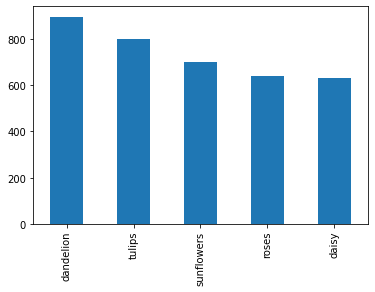

In [15]:
dataframe['category'].value_counts().plot.bar()

## **Plotting a random image**

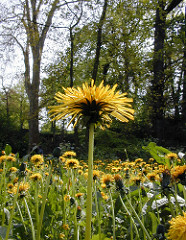

In [18]:
random_image = np.random.choice(filenames)
random_image = tf.keras.preprocessing.image.load_img(random_image)
random_image

In [19]:
random_image = tf.keras.preprocessing.image.img_to_array(random_image)
random_image.shape

(240, 186, 3)

Note: All images are in various shapes

## **Train, test, val Splits**

In [21]:
train_full_df, test_df = train_test_split(dataframe, test_size=0.1, random_state=40)
train_df, val_df = train_test_split(train_full_df, test_size=0.1, random_state=40)

In [22]:
train_df.shape

(2972, 2)

In [23]:
train_length = train_df.shape[0]
test_length = test_df.shape[0]
val_length = val_df.shape[0]

## **Data Augmentation**

Note: If you are using preprocess_input then no need to rescale the image

In [26]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = preprocess_input
)

In [27]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_dir+"/*/",
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 32
)

Found 2972 validated image filenames belonging to 5 classes.


In [28]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [29]:
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    base_dir+"/*/",
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 32
)

Found 331 validated image filenames belonging to 5 classes.


## **Model Building**

In [30]:
mobilenet = MobileNetV2(input_shape=[224, 224, 3], weights='imagenet', include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [31]:
for layer in mobilenet.layers:
  layer.trainable = False

In [32]:
x = tf.keras.layers.GlobalAveragePooling2D()(mobilenet.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

In [33]:
model = tf.keras.models.Model(inputs=mobilenet.input, outputs=x)

In [34]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [35]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #from_logits=false beacause in last predcition layer we specified activation='softmax'
    optimizer='adam',
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch = train_length//32,
    validation_data=val_generator,
    validation_steps=val_length//32,
    callbacks = tf.keras.callbacks.EarlyStopping(patience=3)
)

Epoch 1/5
92/92 [==============================] - 45s 491ms/step - loss: 0.7055 - accuracy: 0.7354 - val_loss: 0.4138 - val_accuracy: 0.8469
Epoch 2/5
92/92 [==============================] - 44s 481ms/step - loss: 0.4345 - accuracy: 0.8425 - val_loss: 0.3063 - val_accuracy: 0.8875
Epoch 3/5
92/92 [==============================] - 44s 476ms/step - loss: 0.3684 - accuracy: 0.8585 - val_loss: 0.2695 - val_accuracy: 0.9062
Epoch 4/5
92/92 [==============================] - 44s 480ms/step - loss: 0.3247 - accuracy: 0.8871 - val_loss: 0.2182 - val_accuracy: 0.9156
Epoch 5/5
92/92 [==============================] - 44s 481ms/step - loss: 0.2973 - accuracy: 0.8901 - val_loss: 0.2334 - val_accuracy: 0.9000


## **Plot Model Performace**

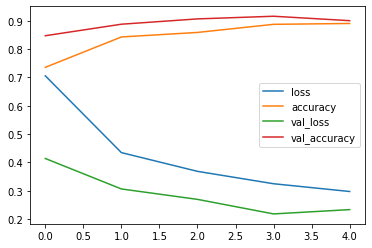

In [37]:
pd.DataFrame(history.history).plot()

In [38]:
test_generator = val_datagen.flow_from_dataframe(
    test_df,
    base_dir+"/*/",
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 32
)

Found 367 validated image filenames belonging to 5 classes.


In [39]:
model.evaluate(test_generator)

12/12 [==============================] - 2s 150ms/step - loss: 0.3425 - accuracy: 0.8883


[0.3425373136997223, 0.888283371925354]